In [11]:
import os
import sys 
from sklearn.decomposition import PCA
from sklearn.utils.extmath import randomized_svd


PROJECT_ROOT_DIR = "latent-communication"

current_dir = os.getcwd()

# Find the project root by walking up the directory tree
while current_dir:
    if os.path.basename(current_dir) == PROJECT_ROOT_DIR:
        break  # Found the project root!
    current_dir = os.path.dirname(current_dir)
else:
    raise FileNotFoundError(f"Project root '{PROJECT_ROOT_DIR}' not found in the directory tree.")

os.chdir(current_dir)
# Add the project root and any necessary subdirectories to sys.path
sys.path.insert(0, current_dir) 
sys.path.insert(0, os.path.join(current_dir, "utils"))  # Add the utils directory if needed

print(os.getcwd())

from pathlib import Path
import torch.nn as nn

import itertools
import torch
import numpy as np
from tqdm import tqdm
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging
from optimization.fit_mapping import create_mapping
from utils.sampler import *
from optimization.optimizer import AffineFitting, ScalingFitting
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

from utils.dataloaders.full_dataloaders import DataLoaderMNIST, DataLoaderFashionMNIST, DataLoaderCIFAR10, DataLoaderCIFAR100
from utils.visualization import (
    visualize_mapping_error,
    visualize_latent_space,
    plot_latent_space,
    highlight_cluster,
)
from utils.model import load_model, get_transformations

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)


/Users/mariotuci/Documents/latent-communication


In [12]:
def clear_memory():
    torch.cuda.empty_cache()

def define_dataloader(file, file2, use_test_set=False):
    if file.strip("_")[0] != file2.strip("_")[0]:
        logging.error("The datasets are different")
    # Define the dataloaders
    name_dataset, name_model, size_of_the_latent, seed = file.strip(".pth").split("_")
    augumentation = get_transformations(name_model)
    if name_dataset.lower() == "mnist":
        dataloader = DataLoaderMNIST(transformation=augumentation, batch_size=64, seed=int(seed))
    if name_dataset.lower() == "fmnist":
        dataloader = DataLoaderFashionMNIST(transformation=augumentation,batch_size=64, seed=int(seed))
    if name_dataset.lower() == "cifar10":
        dataloader = DataLoaderCIFAR10(transformation=augumentation,batch_size=64, seed=int(seed))
    if name_dataset.lower() == "cifar100":
        dataloader = DataLoaderCIFAR100(transformation=augumentation,batch_size=64, seed=int(seed))
    if use_test_set:
        full_dataset_images, full_dataset_labels = dataloader.get_full_test_dataset()
    else:
        full_dataset_images, full_dataset_labels = dataloader.get_full_train_dataset()
    return full_dataset_images, full_dataset_labels, len(np.unique(full_dataset_labels.numpy()))

def load_mapping(path,mapping):
    if mapping == 'Linear':
        from optimization.optimizer import LinearFitting
        mapping = LinearFitting.from_file(path)
    elif mapping == 'Affine':
        from optimization.optimizer import AffineFitting
        mapping = AffineFitting.from_file(path)
    elif mapping == 'NeuralNetwork':
        from optimization.optimizer import NeuralNetworkFitting
        mapping = NeuralNetworkFitting.from_file(path)
    elif mapping == 'Decouple':
        from optimization.optimizer import DecoupleFitting
        mapping = DecoupleFitting.from_file(path)
    else:
        raise ValueError("Invalid experiment name")
    return mapping

In [13]:
##############################################
#Specify here which files you want to use
folder1 = "models/checkpoints/VAE/FMNIST"
folder2 = "models/checkpoints/VAE/FMNIST"
dataset="FMNIST"
number_samples = [50]
mapping_list = ["Affine"]
lamda_list = [0,0.1]
sampling_strategy = "equally"
filter = '_16_' #write here if you want that the processed files contain this string (example "_50_" to only process the files with latent size 50)
###############################################
## this autiomatically creates all the possible setups with the paramenters and the files you speicified, and sets up the correct dataset
files1 = [f for f in os.listdir(folder1) if f.endswith(".pth") and filter in f]
files2 = [f for f in os.listdir(folder2) if f.endswith(".pth") and filter in f]
list_of_files = [(f1, f2) for f1, f2 in itertools.product(files1, files2) if f1 != f2]
combinations_parameters = list(itertools.product(number_samples, mapping_list, lamda_list))
pbar = tqdm(list(itertools.product(list_of_files, combinations_parameters)))
images, labels, n_classes = define_dataloader(files1[0], files2[0], use_test_set=True)
images = images.type(torch.float32)
labels = labels.type(torch.float32)
criterion = nn.MSELoss()
# Result of all the combinations 
results = []

# Get for each class the corresponding indices 
class_indices = {i: np.where(labels.numpy() == i)[0] for i in range(n_classes)}
# Get the corresponding class for each index
indices_class = {i: labels.numpy()[i] for i in range(len(labels))}



for (file1, file2), (num_samples, mapping_name, lamda) in pbar:
  name_dataset1, name_model1, size_of_the_latent1, seed1 = file1.strip(".pth").split("_")
  name_dataset2, name_model2, size_of_the_latent2, seed2 = file2.strip(".pth").split("_")
  #Load model
  model1 = load_model(model_name=name_model1, name_dataset=name_dataset1, latent_size=int(size_of_the_latent1), seed=int(seed1), model_path = folder1 +"/"+ file1)
  model2 = load_model(model_name=name_model2, name_dataset=name_dataset2, latent_size=int(size_of_the_latent2), seed=int(seed2), model_path = folder1 +"/"+ file2)
  #Load mapping
  mapping_path = f'results/transformations/mapping_files/{name_model2}/{file1.strip(".pth")}>{file2.strip(".pth")}>{mapping_name}_{num_samples}_{lamda}_{sampling_strategy}'
  mapping = load_mapping(mapping_path,mapping_name)
  #Calculate latent spaces
  latent_left = model1.get_latent_space(images).detach().cpu().numpy()
  latent_right = model2.get_latent_space(images).detach().cpu().numpy()
  transformed_latent_space = mapping.transform(latent_left)

  # Append dictionary to results
  print(latent_left.shape)
  results.append({
    'latent_left': latent_left,
    'latent_right': latent_right,
    'transformed_latent_space': transformed_latent_space,
    'mapping': mapping
  })
  


  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:01<00:18,  1.64s/it]

(10000, 16)


 17%|█▋        | 2/12 [00:02<00:10,  1.04s/it]

(10000, 16)


 25%|██▌       | 3/12 [00:02<00:07,  1.19it/s]

(10000, 16)


 33%|███▎      | 4/12 [00:03<00:06,  1.30it/s]

(10000, 16)


 42%|████▏     | 5/12 [00:04<00:04,  1.42it/s]

(10000, 16)


 50%|█████     | 6/12 [00:04<00:03,  1.51it/s]

(10000, 16)


 58%|█████▊    | 7/12 [00:05<00:03,  1.58it/s]

(10000, 16)


 67%|██████▋   | 8/12 [00:05<00:02,  1.63it/s]

(10000, 16)


 75%|███████▌  | 9/12 [00:06<00:01,  1.66it/s]

(10000, 16)


 83%|████████▎ | 10/12 [00:06<00:01,  1.69it/s]

(10000, 16)


 92%|█████████▏| 11/12 [00:07<00:00,  1.70it/s]

(10000, 16)


100%|██████████| 12/12 [00:08<00:00,  1.47it/s]

(10000, 16)


In [14]:
import numpy as np

def principal_angles_subspaces(U, V):
    """
    Compute principal angles between two subspaces U and V.
    
    Parameters:
    U : numpy.ndarray
        Orthonormal basis for subspace U, each column is a basis vector.
    V : numpy.ndarray
        Orthonormal basis for subspace V, each column is a basis vector.
    
    Returns:
    angles : numpy.ndarray
        Array containing the principal angles in radians.
    """
    # Compute the matrix U^T * V
    B = np.dot(U.T, V)
    
    # Compute the singular values of B
    singular_values = np.linalg.svd(B, full_matrices=False, compute_uv=False)
    
    # Compute principal angles from the singular values
    angles = np.arccos(singular_values)
    
    return angles

def rotation_matrix_from_svd(U, V):
    """
    Compute the rotation matrix R that aligns subspace V to subspace U
    via principal angles.
    
    Parameters:
    U : numpy.ndarray
        Orthonormal basis for subspace U, each column is a basis vector.
    V : numpy.ndarray
        Orthonormal basis for subspace V, each column is a basis vector.
    
    Returns:
    R : numpy.ndarray
        Rotation matrix that aligns subspace V to subspace U.
    """
    # Compute the matrix U^T * V
    B = np.dot(U.T, V)
    
    # Perform SVD of B
    W, _, Z = np.linalg.svd(B, full_matrices=False)
    
    # Construct rotation matrices R_U and R_V
    R_U = np.dot(U, W)
    R_V = np.dot(V, Z.T)
    
    # Compute the rotation matrix R
    R = np.dot(R_U, R_V.T)
    
    return R

# Example usage:
# Generate random orthonormal bases for subspaces U and V
np.random.seed(0)
U = results[0]['latent_left']
U, _ = np.linalg.qr(U)  # Ensure U is orthonormal
V = results[0]['latent_right']
V, _ = np.linalg.qr(V)  # Ensure V is orthonormal

# Compute the rotation matrix R that aligns V to U via principal angles
R = rotation_matrix_from_svd(U, V)

print("Rotation matrix R:")
print(R)



Rotation matrix R:
[[ 8.4875053e-04 -2.6497705e-04  3.9730102e-04 ...  7.5340807e-04
  -2.0281492e-04 -4.0418957e-04]
 [-5.1705347e-04  5.8370043e-04 -1.5876169e-04 ... -5.7505153e-04
  -3.3288702e-04  1.4929959e-04]
 [ 1.4932797e-04 -4.0250164e-04  7.3935156e-04 ...  6.5119566e-05
  -8.5979162e-05  3.7521648e-05]
 ...
 [ 1.2390628e-04 -6.1507232e-04 -6.3224079e-04 ...  4.6869801e-04
   1.0197737e-03  5.4159574e-04]
 [ 6.5243890e-04 -4.4296836e-04  4.6633848e-04 ...  6.8764982e-04
   3.2681404e-04  3.5911694e-04]
 [ 9.8399134e-05  1.7571702e-04 -1.7052177e-04 ...  2.0794166e-04
   9.3951763e-05 -1.0292650e-04]]


Defining the problem
Solving the problem
Getting results


/Users/mariotuci/miniconda/envs/relreps/lib/python3.8/site-packages/sklearn/utils/extmath.py:368: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


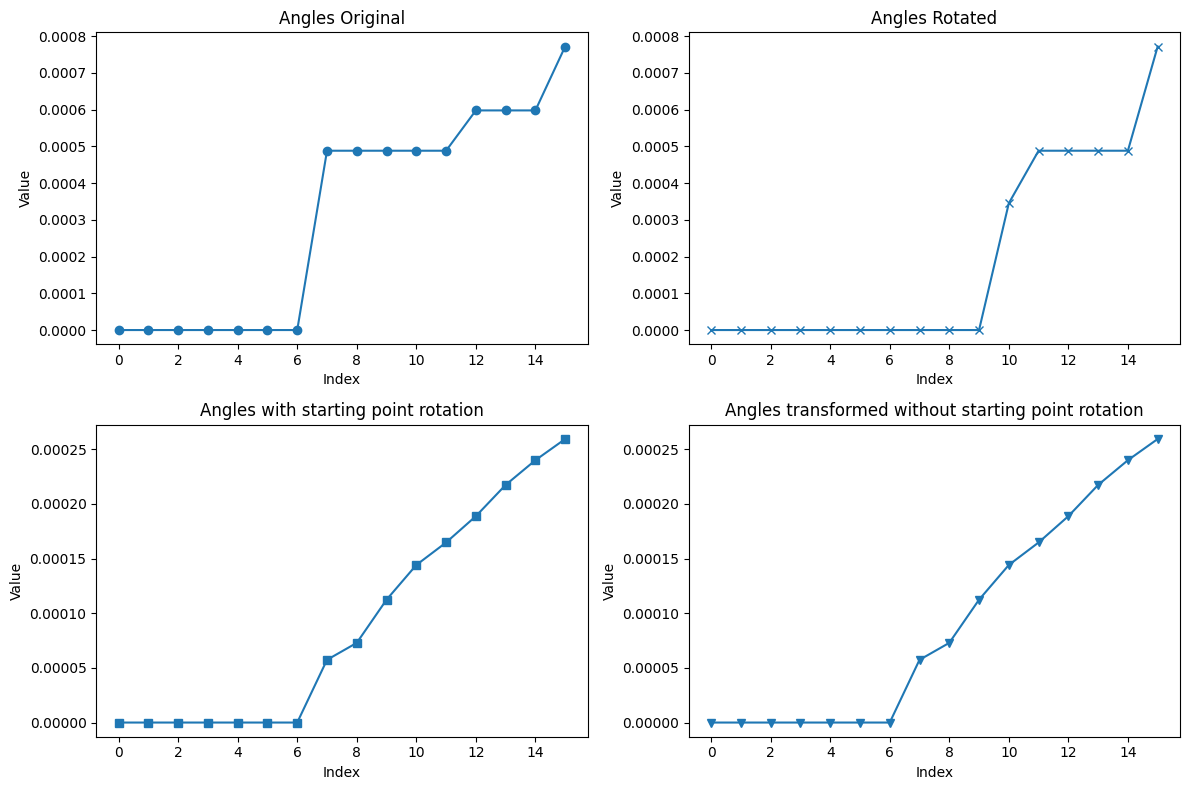

<Figure size 640x480 with 0 Axes>

Defining the problem
Solving the problem
Getting results


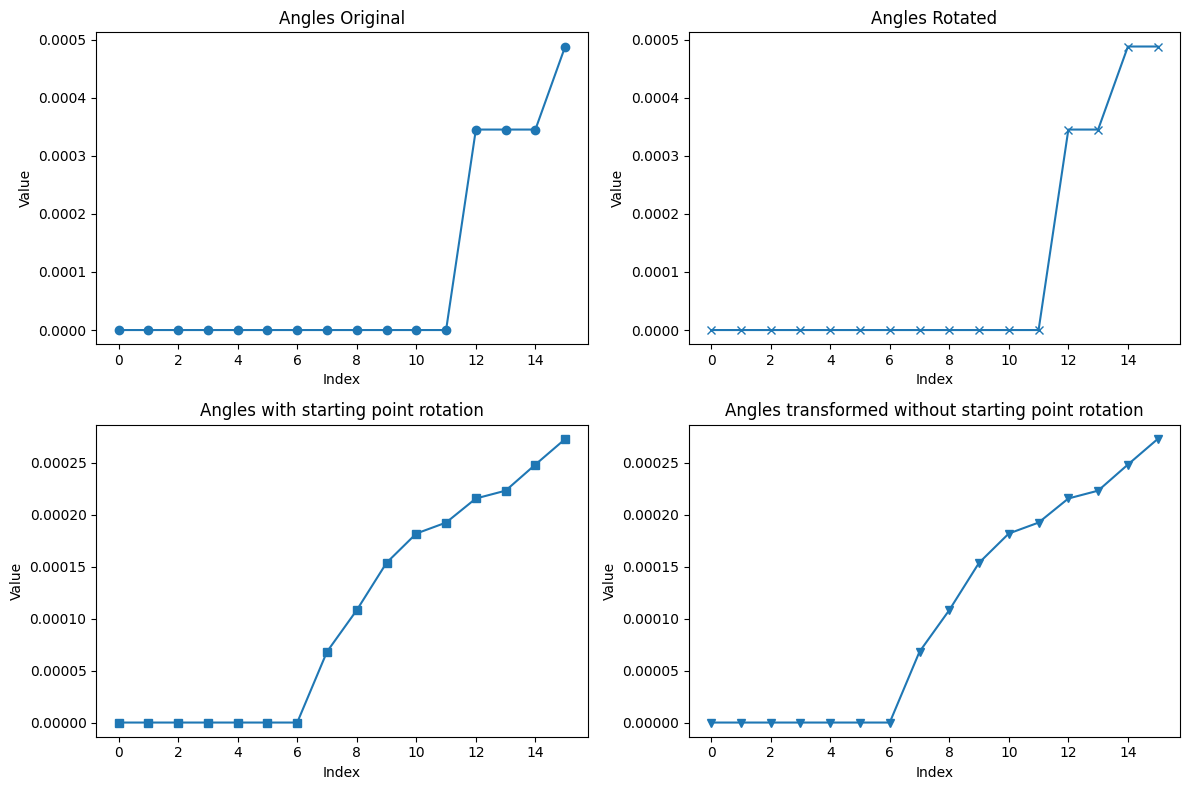

<Figure size 640x480 with 0 Axes>

Defining the problem
Solving the problem
Getting results


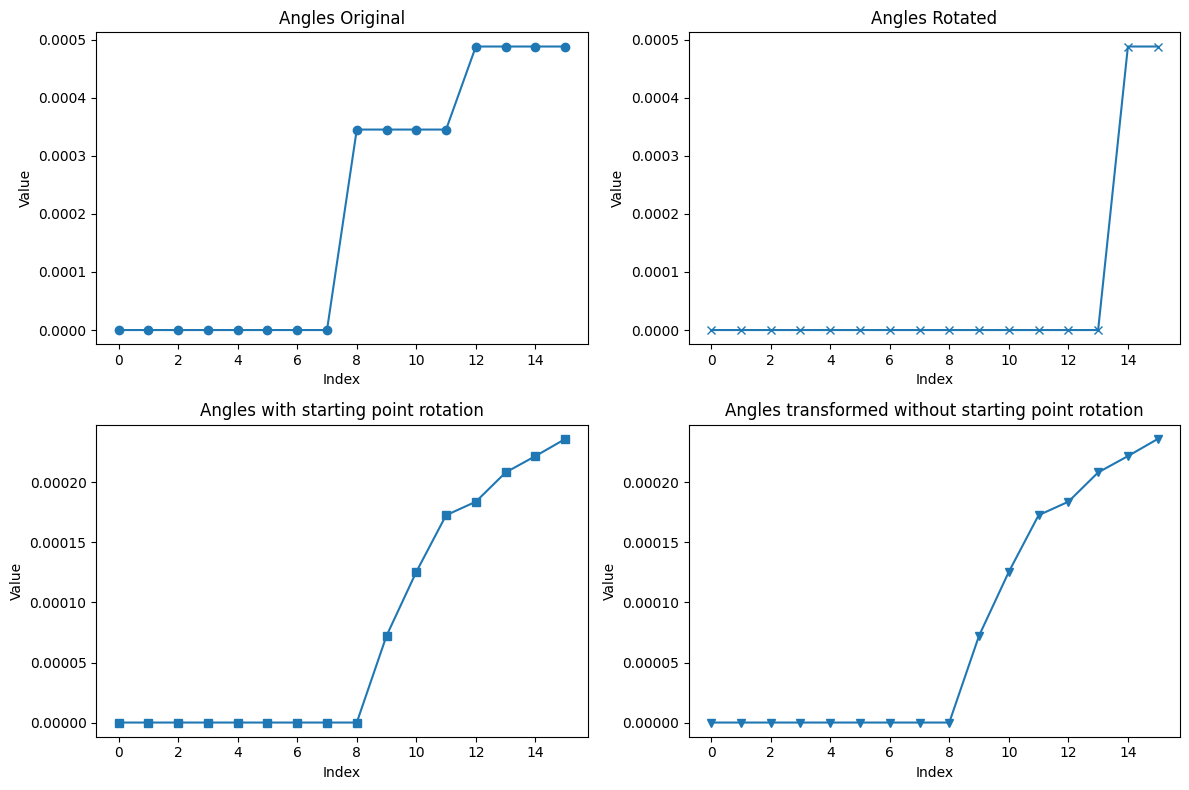

<Figure size 640x480 with 0 Axes>

Defining the problem
Solving the problem
Getting results


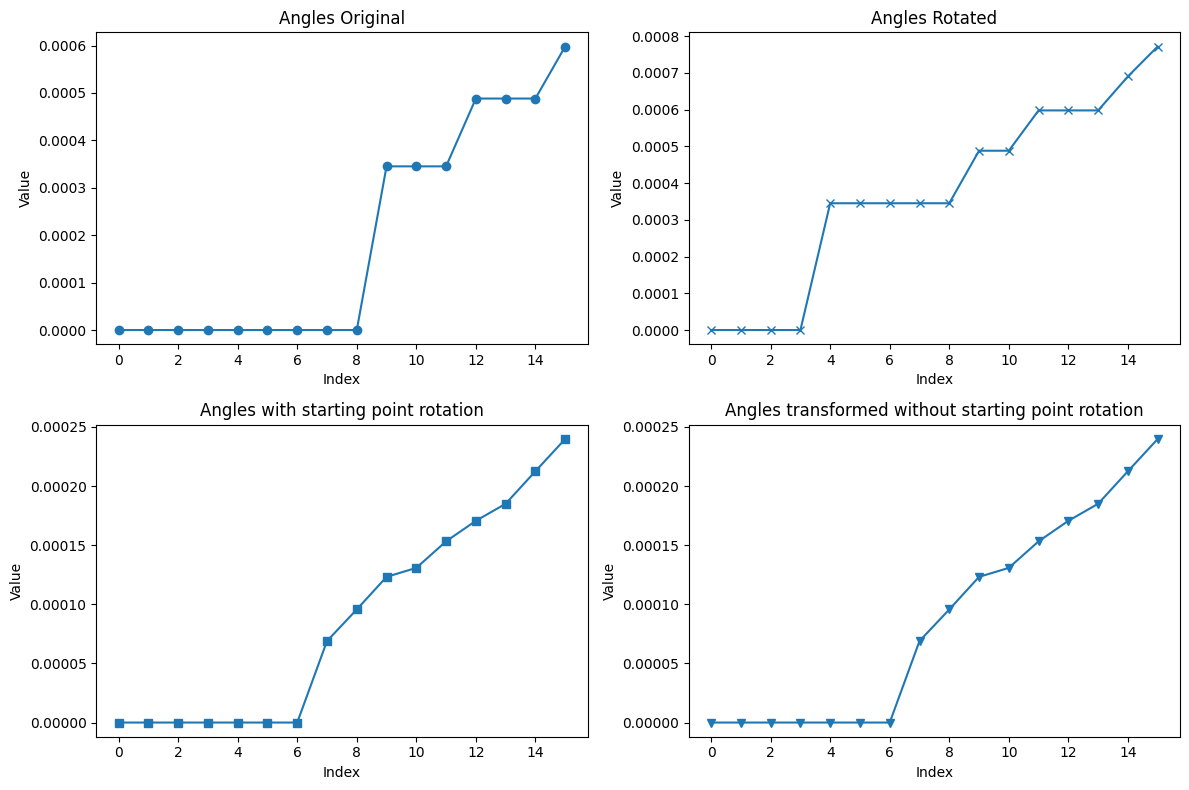

<Figure size 640x480 with 0 Axes>

Defining the problem
Solving the problem
Getting results


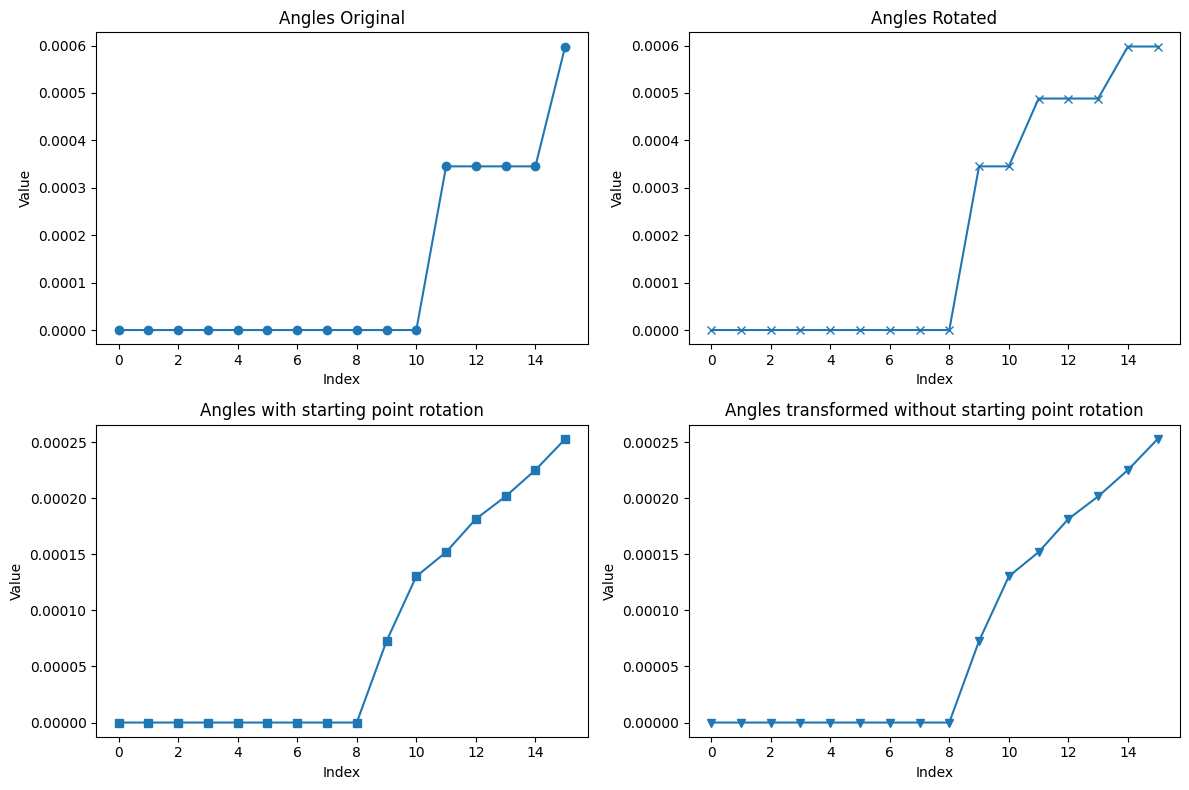

<Figure size 640x480 with 0 Axes>

Defining the problem
Solving the problem
Getting results


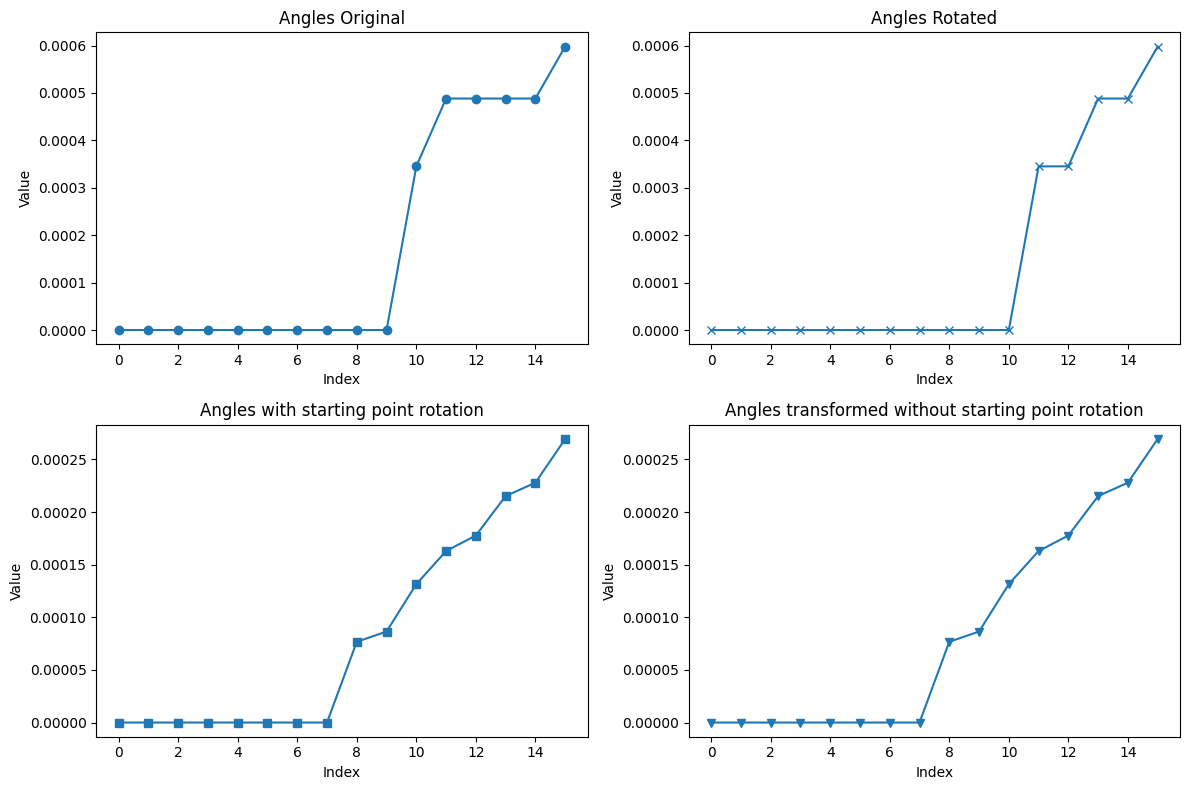

<Figure size 640x480 with 0 Axes>

Defining the problem
Solving the problem
Getting results


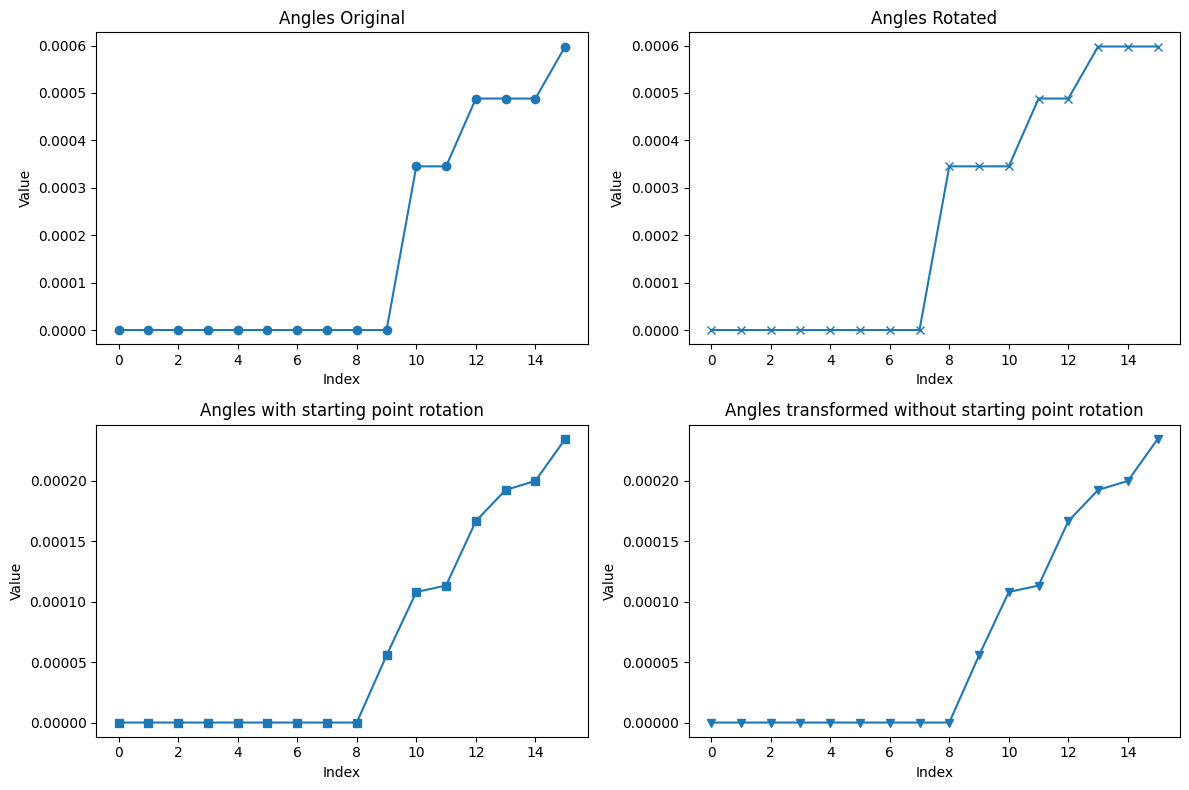

<Figure size 640x480 with 0 Axes>

Defining the problem
Solving the problem
Getting results


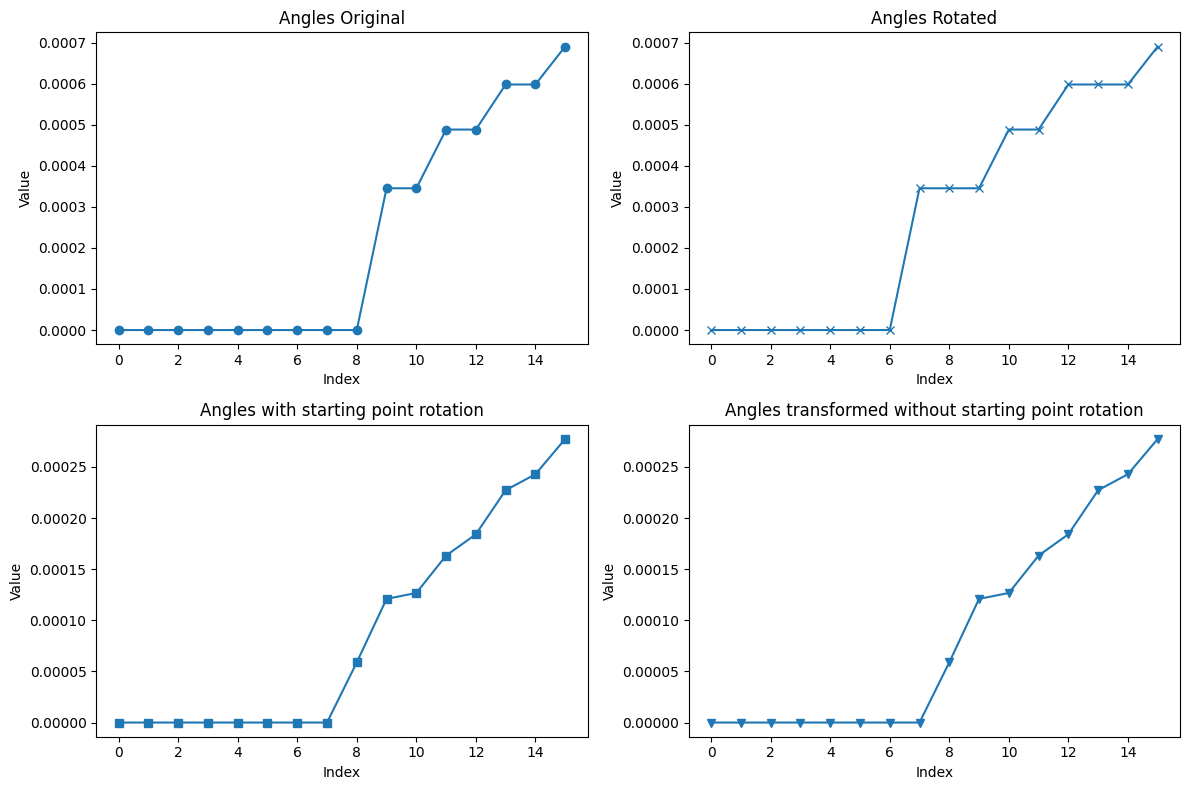

<Figure size 640x480 with 0 Axes>

Defining the problem
Solving the problem
Getting results


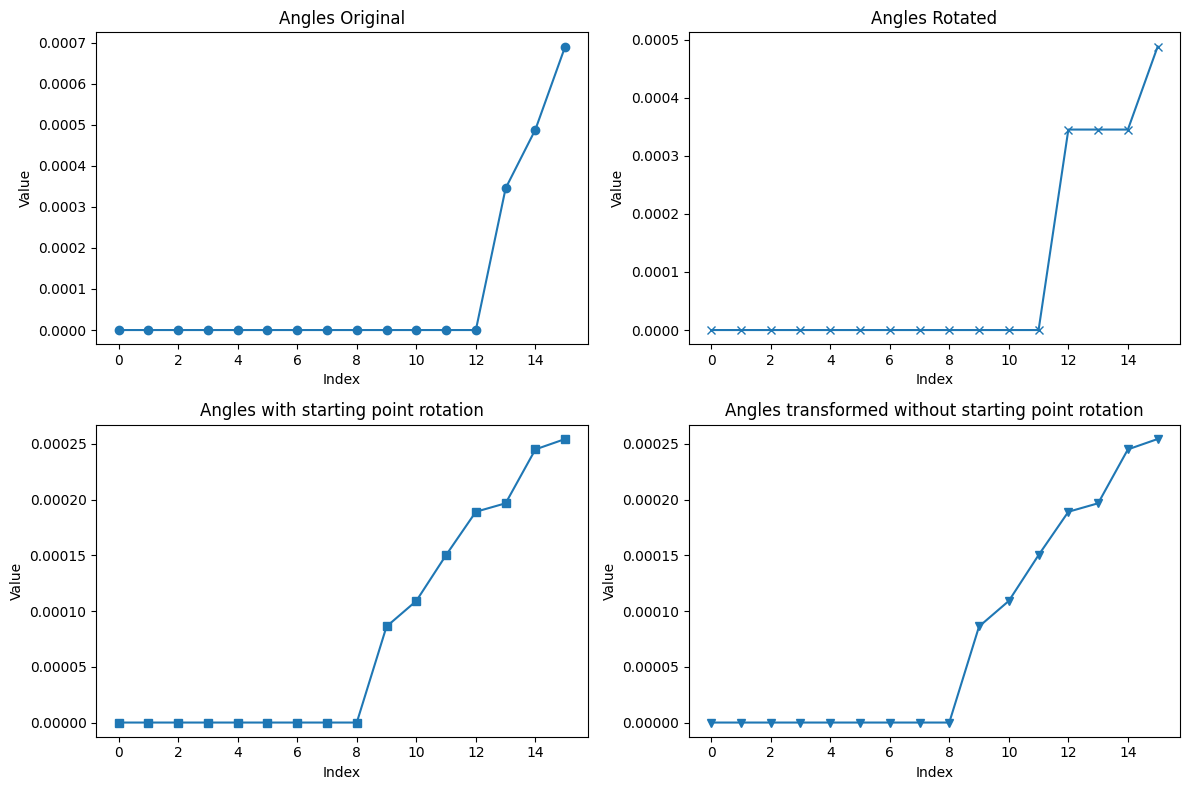

<Figure size 640x480 with 0 Axes>

Defining the problem
Solving the problem


In [16]:
import numpy as np
from sklearn.utils.extmath import randomized_svd

def orthogonalize(X):
    """
    Orthogonalize the matrix X using QR decomposition.
    
    Parameters:
    - X: ndarray of shape (n, k)
      Matrix to be orthogonalized
      
    Returns:
    - X_ortho: ndarray of shape (n, k)
      Orthogonalized matrix
    """
    Q, _ = np.linalg.qr(X)
    return Q

def principal_angles(X, Y):
    """
    Calculate the principal angles between two subspaces spanned by columns of X and Y.
    X and Y are first orthogonalized using QR decomposition before calculating angles.
    
    Parameters:
    - X: ndarray of shape (n, k1)
      Matrix representing the subspace spanned by columns of X
    - Y: ndarray of shape (m, k2)
      Matrix representing the subspace spanned by columns of Y
      
    Returns:
    - angles: ndarray of shape (min(k1, k2),)
      Principal angles between the subspaces spanned by X and Y, in radians.
    """
    # Orthogonalize the matrices
    X_o = orthogonalize(X)
    Y_o = orthogonalize(Y)
    
    # Perform SVD on the product of the orthogonalized subspaces
    _, _, V_x = randomized_svd(X_o.T @ Y_o, n_components=min(X_o.shape[1], Y_o.shape[1]))
    
    # Ensure the singular values are in the valid range [-1, 1]
    singular_values = np.clip(_, -1, 1)

    # Calculate the principal angles from the singular values
    angles = np.arccos(singular_values)
    
    return angles



# Iterate through each pair of results
for pair in results:
    #print(pair['mapping'])
    latent_space1 = np.transpose(pair['latent_left'])
    latent_space2 = np.transpose(pair['latent_right'])
    transformed_latent_space = np.transpose(pair['transformed_latent_space'])
    U = orthogonalize(latent_space1)
    V = orthogonalize(latent_space2)
    R = rotation_matrix_from_svd(U, V)

    rotated_latent_space = R @ latent_space1
   
    # Sample a random pair of indices
    indices = np.random.choice(range(1,10000), size=200, replace=False)

    rotated_latent_space_transpose = np.transpose(rotated_latent_space)
    latent_space_2_transpose = np.transpose(latent_space2)
    latent_space_1_transpose = np.transpose(latent_space1)
    
    lamda = 0

    # Create an instance of AffineFitting
    affine_fitter_with_rotation = AffineFitting(rotated_latent_space_transpose[indices], latent_space_2_transpose[indices], lamda)
    affine_fitter_with_rotation.fit()
   
    #affine_fitter_without_rotation = AffineFitting(latent_space_1_transpose[indices], latent_space_2_transpose[indices], lamda)
    #affine_fitter_without_rotation.fit()

    

    
 
    error_with_rotation, A_with_rotation, b_without_rotation = affine_fitter_with_rotation.get_results()
    #error_without_rotation, A_without_rotation, b_without_rotation = affine_fitter_without_rotation.get_results()

    #affine_fitter_without_rotation.fit()
   
    #print("Frobenious norm between the two matrices: ", np.linalg.norm(A_with_rotation - A_without_rotation))
  
    # Transform the latent space using the new mapping
    transformed_latent_space_rotated = np.transpose(affine_fitter_with_rotation.transform(rotated_latent_space_transpose))
    
    #transformed_latent_space_without= np.transpose(affine_fitter_without_rotation.transform(latent_space_1_transpose))
    # Calculate the principal angles between the two latent spaces
    angles_with_rotation_transformed = principal_angles(transformed_latent_space_rotated, latent_space2)

    angles_without_rotation_tranformed = principal_angles(transformed_latent_space, latent_space2)

    angles_with_rotation = principal_angles(rotated_latent_space, latent_space2)
   
    # Calculate the principal angles between the two latent spaces
    angles_original = principal_angles(latent_space1, latent_space2)
    #print(angles_original)
   #
    # Angles rounded to 3 decimal places
    angles_rotated = principal_angles(rotated_latent_space, latent_space2)
    
   



      # Create the figure and subplots
    plt.figure(figsize=(12, 8))

    # First subplot for angles_original
    plt.subplot(2, 2, 1)
    plt.plot(angles_original, marker='o')
    plt.title("Angles Original")
    plt.xlabel("Index")
    plt.ylabel("Value")

    # Second subplot for angles_transformed
    plt.subplot(2, 2, 2)
    plt.plot(angles_rotated, marker='x')
    plt.title("Angles Rotated")
    plt.xlabel("Index")
    plt.ylabel("Value")

    # Third subplot for differences
    plt.subplot(2, 2, 3)
    plt.plot(angles_with_rotation_transformed, marker='s')
    plt.title("Angles with starting point rotation")
    plt.xlabel("Index")
    plt.ylabel("Value")

    # Fourth subplot for angles_rotated
    plt.subplot(2, 2, 4)
    plt.plot(angles_without_rotation_tranformed, marker='v')
    plt.title("Angles transformed without starting point rotation")
    plt.xlabel("Index")
    plt.ylabel("Value")

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()
 
    
    # Show the plots for this pair
    plt.tight_layout()
    plt.show()